In [1]:
!pip install pyspark
!pip install nltk
!pip install transformers torch
!pip install pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, explode, split, count, when, udf
from pyspark.sql.types import ArrayType, StringType, FloatType
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from transformers import pipeline

In [4]:
## LOAD AND INSPECT DATASET

# Download stopwords
nltk.download('stopwords')

# Initialize Spark session
spark = SparkSession.builder.appName("Tweets").getOrCreate()

# File upload (manual upload)
uploaded = files.upload() # Upload the CSV file
file_name = list(uploaded.keys())[0] # Get the filename dynamically

# Load the dataset into PySpark DataFrame
df = spark.read.csv(file_name, header=True, inferSchema=True)

# Show raw data
df.show(30, truncate=False)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving Midterm-Data.csv to Midterm-Data.csv
+-----------------------------------------------------------------------------------------------------------------------------------------------+
|tweets                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run                                         |
|@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked                     |
|  bihday your majesty                                                                                                                          |
|#model   i love u take with u all the time in urð±!!! ððððð¦ð

In [12]:
## DATA PREPROCESSING

# Preprocessing Steps
## Remove special characters and punctuation from tweets
df = df.withColumn("tweets", regexp_replace(col("tweets"), r"[^a-zA-Z\s]", ""))

## Convert to lowercase
df = df.withColumn("tweets", lower(col("tweets")))

# Tokenization
df = df.withColumn("words",split(col("tweets"), " "))

# Stopword Removal
stop_words = set(stopwords.words("english"))
additional_stopwords = {"user", "im", " ", "u", "amp", "day", "get", "if", "all", "ur", "one", "people"} # Customize as needed stop_words.update(additional_stopwords)
def remove_stopwords(words):
  return [word for word in words if word not in stop_words and word != ""]

remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))
df = df.withColumn("filtered_words", remove_stopwords_udf(col("words")))



In [11]:
#Word Frequency Analysis
df_exploded = df.select(explode(col("filtered_words")).alias("word"))
df_exploded = df_exploded.filter(~col("word").isin(additional_stopwords))
word_counts = df_exploded.groupBy("word").count().orderBy(col ("count").desc())

## Display Top 30 Words
word_counts.show(30)

+---------+-----+
|     word|count|
+---------+-----+
|     love|   94|
|    happy|   54|
| thankful|   38|
| positive|   33|
|     good|   32|
|   bihday|   31|
|     like|   31|
|     time|   31|
|     life|   30|
|    today|   27|
|      new|   26|
|     dont|   26|
|     take|   25|
|  fathers|   23|
|     know|   21|
|  healthy|   20|
|     work|   20|
|    right|   20|
|       go|   19|
|     want|   19|
|      see|   19|
|   family|   19|
|  weekend|   19|
|     days|   18|
|     back|   18|
|  orlando|   18|
|beautiful|   18|
|     blog|   17|
|     gold|   17|
|     home|   17|
+---------+-----+
only showing top 30 rows



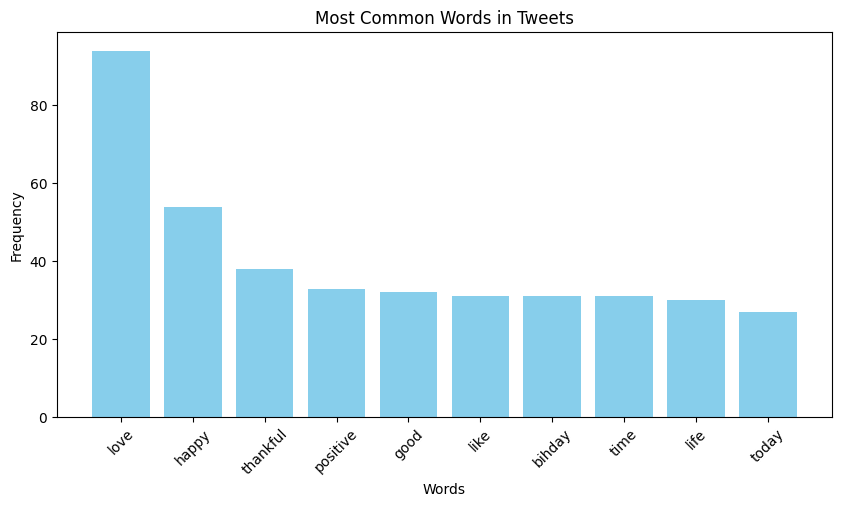

In [13]:

# Convert to Pandas for visualization
word_counts_pd = word_counts.limit(10).toPandas()
# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(word_counts_pd["word"], word_counts_pd["count"], color="skyblue")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Tweets")
plt.xticks(rotation=45)
plt.show()



In [22]:
# HYPERPARAMETERS
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english" # Change to another BERT model
BATCH_SIZE = 16 # Number of texts processed per batch (increase for speed)
MAX_LENGTH = 512 # Truncate text after 512 tokens
CONFIDENCE_THRESHOLD = 0.5 # If confidence < 0.75, classify as NEUTRAL

In [23]:
# Load BERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=MODEL_NAME)
def get_sentiment(text):
  if text:
    result = sentiment_pipeline(text[:MAX_LENGTH], truncation=True)[0] # Limit to max tokens
    label, score = result['label'], result['score']

    # Apply confidence threshold
    if score < CONFIDENCE_THRESHOLD:
      return "NEUTRAL"
    elif label == "POSITIVE":
      return "POSITIVE"
    else:
      return "NEGATIVE"
      return "NEUTRAL"

Device set to use cpu


In [24]:
# Define PySpark UDF for sentiment classification

sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis
df = df.withColumn("sentiment", sentiment_udf(col("tweets")))

In [25]:
# Show sentiment results with scores
df.select("tweets", "sentiment").show(30, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+---------+
|tweets                                                                                                                           |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------+---------+
| user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run                              |NEGATIVE |
|user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthanked               |NEGATIVE |
|  bihday your majesty                                                                                                            |POSITIVE |
|model   i love u take with u all the time in ur                                                                                  |POSITIVE |
| fact

In [26]:
#Count of each sentiment category
df.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| POSITIVE|  461|
| NEGATIVE|  538|
+---------+-----+



HYPERPARAMETER COMBINATION 2

In [27]:
# HYPERPARAMETERS
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english" # Change to another BERT model
BATCH_SIZE = 32 # Number of texts processed per batch (increase for speed)
MAX_LENGTH = 256 # Truncate text after 512 tokens
CONFIDENCE_THRESHOLD = 0.75 # If confidence < 0.75, classify as NEUTRAL

In [28]:
# Load BERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=MODEL_NAME)
def get_sentiment(text):
  if text:
    result = sentiment_pipeline(text[:MAX_LENGTH], truncation=True)[0] # Limit to max tokens
    label, score = result['label'], result['score']

    # Apply confidence threshold
    if score < CONFIDENCE_THRESHOLD:
      return "NEUTRAL"
    elif label == "POSITIVE":
      return "POSITIVE"
    else:
      return "NEGATIVE"
      return "NEUTRAL"

Device set to use cpu


In [29]:
# Define PySpark UDF for sentiment classification

sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis
df = df.withColumn("sentiment", sentiment_udf(col("tweets")))

 # Creates a new column "sentiment" in the DataFrame.
 # Applies the UDF to classify sentiment for each row in the "responses" column.

In [30]:
# Show sentiment results with scores
df.select("tweets", "sentiment").show(30, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+---------+
|tweets                                                                                                                           |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------+---------+
| user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run                              |NEGATIVE |
|user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthanked               |NEGATIVE |
|  bihday your majesty                                                                                                            |POSITIVE |
|model   i love u take with u all the time in ur                                                                                  |POSITIVE |
| fact

In [31]:
#Count of each sentiment category
df.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| POSITIVE|  432|
| NEGATIVE|  505|
|  NEUTRAL|   62|
+---------+-----+



HYPERPARAMATER COMBINATION 3

In [32]:
# HYPERPARAMETERS
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english" # Change to another BERT model
BATCH_SIZE = 8 # Number of texts processed per batch (increase for speed)
MAX_LENGTH = 128 # Truncate text after 512 tokens
CONFIDENCE_THRESHOLD = 0.75 # If confidence < 0.75, classify as NEUTRAL

In [33]:
# Load BERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=MODEL_NAME)
def get_sentiment(text):
  if text:
    result = sentiment_pipeline(text[:MAX_LENGTH], truncation=True)[0] # Limit to max tokens
    label, score = result['label'], result['score']

    # Apply confidence threshold
    if score < CONFIDENCE_THRESHOLD:
      return "NEUTRAL"
    elif label == "POSITIVE":
      return "POSITIVE"
    else:
      return "NEGATIVE"
      return "NEUTRAL"

Device set to use cpu


In [34]:
# Define PySpark UDF for sentiment classification

sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis
df = df.withColumn("sentiment", sentiment_udf(col("tweets")))

In [35]:
# Show sentiment results with scores
df.select("tweets", "sentiment").show(30, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+---------+
|tweets                                                                                                                           |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------+---------+
| user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run                              |NEGATIVE |
|user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthanked               |NEGATIVE |
|  bihday your majesty                                                                                                            |POSITIVE |
|model   i love u take with u all the time in ur                                                                                  |POSITIVE |
| fact

In [36]:
#Count of each sentiment category
df.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| POSITIVE|  432|
| NEGATIVE|  505|
|  NEUTRAL|   62|
+---------+-----+



HYPERPARAMETER COMBINATION 4

In [37]:
# HYPERPARAMETERS
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english" # Change to another BERT model
BATCH_SIZE = 64 # Number of texts processed per batch (increase for speed)
MAX_LENGTH = 512 # Truncate text after 512 tokens
CONFIDENCE_THRESHOLD = 0.85 # If confidence < 0.75, classify as NEUTRAL

In [38]:
# Load BERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=MODEL_NAME).
def get_sentiment(text):
  if text:
    result = sentiment_pipeline(text[:MAX_LENGTH], truncation=True)[0] # Limit to max tokens
    label, score = result['label'], result['score']

    # Apply confidence threshold
    if score < CONFIDENCE_THRESHOLD:
      return "NEUTRAL"
    elif label == "POSITIVE":
      return "POSITIVE"
    else:
      return "NEGATIVE"
      return "NEUTRAL"

Device set to use cpu


In [39]:
# Define PySpark UDF for sentiment classification

sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis
df = df.withColumn("sentiment", sentiment_udf(col("tweets")))

In [40]:
# Show sentiment results with scores
df.select("tweets", "sentiment").show(30, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+---------+
|tweets                                                                                                                           |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------+---------+
| user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run                              |NEGATIVE |
|user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthanked               |NEGATIVE |
|  bihday your majesty                                                                                                            |POSITIVE |
|model   i love u take with u all the time in ur                                                                                  |POSITIVE |
| fact

In [41]:
#Count of each sentiment category
df.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| POSITIVE|  419|
| NEGATIVE|  491|
|  NEUTRAL|   89|
+---------+-----+



HYPERPARAMETER COMBINATION 5

In [42]:
# HYPERPARAMETERS
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english" # Change to another BERT model
BATCH_SIZE = 32 # Number of texts processed per batch (increase for speed)
MAX_LENGTH = 512 # Truncate text after 512 tokens
CONFIDENCE_THRESHOLD = 0.9 # If confidence < 0.75, classify as NEUTRAL

In [43]:
# Load BERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=MODEL_NAME)

def get_sentiment(text):
  if text:
    result = sentiment_pipeline(text[:MAX_LENGTH], truncation=True)[0] # Limit to max tokens
    label, score = result['label'], result['score']

    # Apply confidence threshold
    if score < CONFIDENCE_THRESHOLD:
      return "NEUTRAL"
    elif label == "POSITIVE":
      return "POSITIVE"
    else:
      return "NEGATIVE"
      return "NEUTRAL"

Device set to use cpu


In [44]:
# Define PySpark UDF for sentiment classification

sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis
df = df.withColumn("sentiment", sentiment_udf(col("tweets")))

In [45]:
# Show sentiment results with scores
df.select("tweets", "sentiment").show(30, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+---------+
|tweets                                                                                                                           |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------+---------+
| user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run                              |NEGATIVE |
|user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthanked               |NEGATIVE |
|  bihday your majesty                                                                                                            |POSITIVE |
|model   i love u take with u all the time in ur                                                                                  |POSITIVE |
| fact

In [46]:
#Count of each sentiment category
df.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| POSITIVE|  404|
| NEGATIVE|  474|
|  NEUTRAL|  121|
+---------+-----+

